
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.10?urlpath=lab/tree/cta_data_analysis.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[cta_data_analysis.ipynb](../_static/notebooks/cta_data_analysis.ipynb) |
[cta_data_analysis.py](../_static/notebooks/cta_data_analysis.py)
</div>


![CTA first data challenge logo](images/cta-1dc.png)

# CTA data analysis with Gammapy

## Introduction

**This notebook shows an example how to make a sky image and spectrum for simulated CTA data with Gammapy.**

The dataset we will use is three observation runs on the Galactic center. This is a tiny (and thus quick to process and play with and learn) subset of the simulated CTA dataset that was produced for the first data challenge in August 2017.

**This notebook can be considered part 2 of the introduction to CTA 1DC analysis. Part one is here: [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb)**

## Setup

As usual, we'll start with some setup ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!gammapy info --no-envvar --no-system


Gammapy package:

	path                   : /Users/jer/git/gammapy/gammapy/gammapy 
	version                : 0.10 
	githash                : c6bfb5371a5a1682cea9aaf56ebedb3c42010a43 


Other packages:

	numpy                  : 1.16.0     
	scipy                  : 1.2.0      
	matplotlib             : 3.0.2      
	cython                 : 0.29.3     
	astropy                : 3.1.1      
	astropy_healpix        : 0.4        
	reproject              : 0.4        
	sherpa                 : 4.10.2     
	pytest                 : 4.1.1      
	sphinx                 : 1.8.3      
	healpy                 : 1.12.8     
	regions                : 0.3        
	iminuit                : 1.3.3      
	naima                  : 0.8.3      
	uncertainties          : 3.0.3      



In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.utils.energy import EnergyBounds
from gammapy.data import DataStore
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)
from gammapy.maps import Map, MapAxis, WcsNDMap, WcsGeom
from gammapy.cube import MapMaker
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.detect import TSMapEstimator, find_peaks

In [4]:
# Configure the logger, so that the spectral analysis
# isn't so chatty about what it's doing.
import logging

logging.basicConfig()
log = logging.getLogger("gammapy.spectrum")
log.setLevel(logging.ERROR)

## Select observations

Like explained in [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb), a Gammapy analysis usually starts by creating a `DataStore` and selecting observations.

This is shown in detail in the other notebook, here we just pick three observations near the galactic center.

In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps")

In [6]:
# Just as a reminder: this is how to select observations
# from astropy.coordinates import SkyCoord
# table = data_store.obs_table
# pos_obs = SkyCoord(table['GLON_PNT'], table['GLAT_PNT'], frame='galactic', unit='deg')
# pos_target = SkyCoord(0, 0, frame='galactic', unit='deg')
# offset = pos_target.separation(pos_obs).deg
# mask = (1 < offset) & (offset < 2)
# table = table[mask]
# table.show_in_browser(jsviewer=True)

In [7]:
obs_id = [110380, 111140, 111159]
observations = data_store.get_observations(obs_id)

In [8]:
obs_cols = ["OBS_ID", "GLON_PNT", "GLAT_PNT", "LIVETIME"]
data_store.obs_table.select_obs_id(obs_id)[obs_cols]

<ObservationTable length=3>
OBS_ID      GLON_PNT           GLAT_PNT      LIVETIME
              deg                deg            s    
int64       float64            float64       float64 
------ ------------------ ------------------ --------
110380  359.9999912037958 -1.299995937905366   1764.0
111140  358.4999833830074 1.3000020211954284   1764.0
111159 1.5000056568267741  1.299940468335294   1764.0

## Make sky images

### Define map geometry

Select the target position and define an ON region for the spectral analysis

In [9]:
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), npix=(500, 400), binsz=0.02, coordsys="GAL", axes=[axis]
)
geom

WcsGeom

	axes       : lon, lat, energy
	shape      : (500, 400, 9)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 8.0 deg

### Compute images

Exclusion mask currently unused. Remove here or move to later in the tutorial?

In [10]:
target_position = SkyCoord(0, 0, unit="deg", frame="galactic")
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

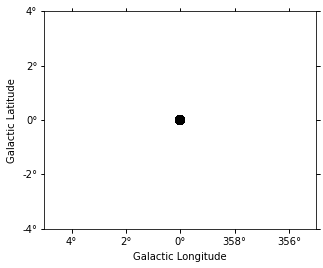

In [11]:
exclusion_mask = geom.to_image().region_mask([on_region], inside=False)
exclusion_mask = WcsNDMap(geom.to_image(), exclusion_mask)
exclusion_mask.plot();

In [12]:
%%time
maker = MapMaker(geom, offset_max="2 deg")
maps = maker.run(observations)
print(maps.keys())

dict_keys(['counts', 'exposure', 'background'])
CPU times: user 3.54 s, sys: 512 ms, total: 4.05 s
Wall time: 4.11 s


In [13]:
# The maps are cubes, with an energy axis.
# Let's also make some images:
images = maker.make_images()

excess = images["counts"].copy()
excess.data -= images["background"].data
images["excess"] = excess

### Show images

Let's have a quick look at the images we computed ...

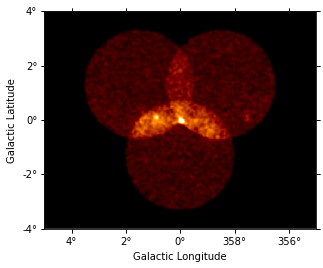

In [14]:
images["counts"].smooth(2).plot(vmax=5);

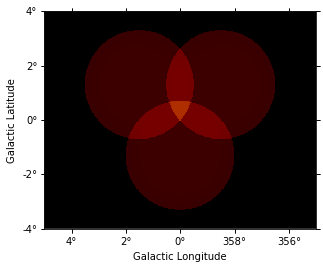

In [15]:
images["background"].plot(vmax=5);

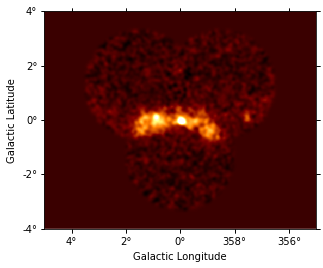

In [16]:
images["excess"].smooth(3).plot(vmax=2);

## Source Detection

Use the class [gammapy.detect.TSMapEstimator](../api/gammapy.detect.TSMapEstimator.rst) and [gammapy.detect.find_peaks](../api/gammapy.detect.find_peaks.rst) to detect sources on the images:

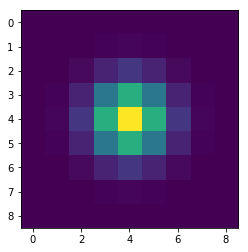

In [17]:
kernel = Gaussian2DKernel(1, mode="oversample").array
plt.imshow(kernel);

In [18]:
%%time
ts_image_estimator = TSMapEstimator()
images_ts = ts_image_estimator.run(images, kernel)
print(images_ts.keys())

dict_keys(['ts', 'sqrt_ts', 'flux', 'flux_err', 'flux_ul', 'niter'])
CPU times: user 1.02 s, sys: 139 ms, total: 1.16 s
Wall time: 11.5 s


In [19]:
sources = find_peaks(images_ts["sqrt_ts"], threshold=8)
sources

<Table length=2>
 value    x     y       ra       dec   
                       deg       deg   
float32 int64 int64  float64   float64 
------- ----- ----- --------- ---------
 21.389   252   197 266.42400 -29.00490
 10.278   207   204 266.82019 -28.16314

In [20]:
source_pos = SkyCoord(sources["ra"], sources["dec"])
source_pos

<SkyCoord (ICRS): (ra, dec) in deg
    [(266.42399798, -29.00490483), (266.82018801, -28.16313964)]>

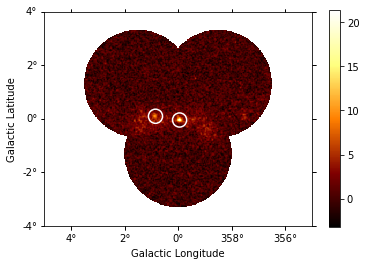

In [21]:
# Plot sources on top of significance sky image
images_ts["sqrt_ts"].plot(add_cbar=True)

plt.gca().scatter(
    source_pos.ra.deg,
    source_pos.dec.deg,
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="white",
    marker="o",
    s=200,
    lw=1.5,
);

## Spatial analysis

See other notebooks for how to run a 3D cube or 2D image based analysis.

## Spectrum

We'll run a spectral analysis using the classical reflected regions background estimation method,
and using the on-off (often called WSTAT) likelihood function.

### Extraction

The first step is to "extract" the spectrum, i.e. 1-dimensional counts and exposure and background vectors, as well as an energy dispersion matrix from the data and IRFs.

/Users/jer/anaconda/envs/gammapy-dev/lib/python3.7/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


CPU times: user 3.44 s, sys: 144 ms, total: 3.58 s
Wall time: 3.49 s


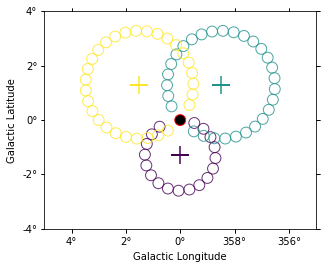

In [22]:
%%time
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    observations=observations,
    on_region=on_region,
    exclusion_mask=exclusion_mask,
)
bkg_estimator.run()
bkg_estimate = bkg_estimator.result
bkg_estimator.plot();

In [23]:
%%time
extract = SpectrumExtraction(
    observations=observations, bkg_estimate=bkg_estimate
)
extract.run()
observations = extract.spectrum_observations

CPU times: user 917 ms, sys: 17.9 ms, total: 935 ms
Wall time: 988 ms


### Model fit

The next step is to fit a spectral model, using all data (i.e. a "global" fit, using all energies).

In [24]:
%%time
model = models.PowerLaw(
    index=2, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
fit = SpectrumFit(observations, model)
fit.run()
print(fit.result[0])


Fit result info 
--------------- 
Model: PowerLaw

Parameters: 

	   name     value     error        unit      min max frozen
	--------- --------- --------- -------------- --- --- ------
	    index 2.225e+00 2.616e-02                nan nan  False
	amplitude 3.013e-12 1.396e-13 cm-2 s-1 TeV-1 nan nan  False
	reference 1.000e+00 0.000e+00            TeV nan nan   True

Covariance: 

	   name     index    amplitude  reference
	--------- ---------- ---------- ---------
	    index  6.842e-04 -9.885e-16 0.000e+00
	amplitude -9.885e-16  1.950e-26 0.000e+00
	reference  0.000e+00  0.000e+00 0.000e+00 

Statistic: 91.148 (wstat)
Fit Range: [1.e-02 1.e+02] TeV

CPU times: user 304 ms, sys: 7.01 ms, total: 311 ms
Wall time: 314 ms


### Spectral points

Finally, let's compute spectral points. The method used is to first choose an energy binning, and then to do a 1-dim likelihood fit / profile to compute the flux and flux error.

In [25]:
# Flux points are computed on stacked observation
stacked_obs = extract.spectrum_observations.stack()
print(stacked_obs)

*** Observation summary report ***
Observation Id: [110380-111159]
Livetime: 1.470 h
On events: 2377
Off events: 34876
Alpha: 0.041
Bkg events in On region: 1434.36
Excess: 942.64
Excess / Background: 0.66
Gamma rate: 10.69 1 / min
Bkg rate: 0.23 1 / min
Sigma: 22.18
energy range: 0.01 TeV - 100.00 TeV


In [26]:
ebounds = EnergyBounds.equal_log_spacing(1, 40, 4, unit=u.TeV)

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
seg.compute_groups_fixed(ebounds=ebounds)

fpe = FluxPointEstimator(
    obs=stacked_obs, groups=seg.groups, model=fit.result[0].model
)
flux_points = fpe.run()
flux_points.table_formatted

<Table length=4>
 e_ref   e_min   e_max  ...     dnde_err       dnde_errp       dnde_errn   
  TeV     TeV     TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV) 1 / (cm2 s TeV)
float64 float64 float64 ...     float64         float64         float64    
------- ------- ------- ... --------------- --------------- ---------------
  1.565   1.000   2.448 ...       1.234e-13       1.273e-13       1.196e-13
  3.831   2.448   5.995 ...       1.942e-14       2.026e-14       1.863e-14
 10.000   5.995  16.681 ...       2.628e-15       2.795e-15       2.466e-15
 26.102  16.681  40.842 ...       4.145e-16       4.768e-16       3.569e-16

### Plot

Let's plot the spectral model and points. You could do it directly, but there is a helper class.
Note that a spectral uncertainty band, a "butterfly" is drawn, but it is very thin, i.e. barely visible.

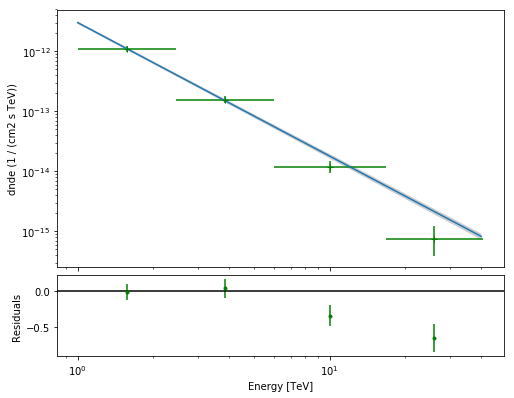

In [27]:
total_result = SpectrumResult(model=fit.result[0].model, points=flux_points)

total_result.plot(
    energy_range=[1, 40] * u.TeV,
    fig_kwargs=dict(figsize=(8, 8)),
    point_kwargs=dict(color="green"),
);

## Exercises

* Re-run the analysis above, varying some analysis parameters, e.g.
    * Select a few other observations
    * Change the energy band for the map
    * Change the spectral model for the fit
    * Change the energy binning for the spectral points
* Change the target. Make a sky image and spectrum for your favourite source.
    * If you don't know any, the Crab nebula is the "hello world!" analysis of gamma-ray astronomy.

In [28]:
# print('hello world')
# SkyCoord.from_name('crab')

## What next?

* This notebook showed an example of a first CTA analysis with Gammapy, using simulated 1DC data.
* This was part 2 for CTA 1DC turorial, the first part was here: [cta_1dc_introduction.ipynb](cta_1dc_introduction.ipynb)
* More tutorials (not 1DC or CTA specific) with Gammapy are [here](../index.ipynb)
* Let us know if you have any question or issues!